# Masking of Data

After an experiment has been performed, there are usually some parts of the data that contain noise or background. Whether these parts are spurious signals or well established background does not play an important role. In order to mask them out, a set of masks have been created, covering masks in 1D, 2D and 3D. Due to the ambiguity in defining e.g. a box in 3D, it is advantageous to generate a mask for then to plot it in an axes. This can be done either in 2D or 3D as needed, but notice that 1D masks are not possible to plot.

The following masks are available:

| Mask          | Dimensionality | Description                                 |
|---------------|:--------------:|---------------------------------------------|
| lineMask      |       1D       | Mask relative to two values                 |
| indexMask     |       1D       | Mask relative to two indices                |
| circleMask    |       2D       | Mask values inside or outside a circle      |
| rectangleMask |       2D       | Mask values inside or outside a rectangle   |
| boxMask       |       3D       | Mask values inside or outside a box         |
| curratAxeMask |       N/A      | Mask out Currat-Axe for specified HKL point |



When a mask is generated, one can specify the coordinates in which the masking is to take place. Usually, this is going to be the $H$, $K$, $L$, and $E$ axis of the data, but others are also supported. This also means that plotting the mask on to of the data provides some difficulty. This is the reason behind the “transformation” argument of the plot method. It takes a function as input which converts between the chosen coordinates and the plotted ones; an example will be shown below.

Most often, masking is to be performed in many coordinates that might depend on each other. This could be masking Bragg peaks, where the position is known in ($H$, $K$, $L$) but only for a limited energy range. This means that masks are to be merged either using a boolean “and” or “or” command.

Commands to combine masks:

- <code> * </code> AND, requires both masks to be true for region to be masked
- <code> + </code> OR, requires either masks to be true for region to be masked
- <code> - </code> OR NOT, requires first mask to be true or second mask to be false to mask region

In principle one can also utilize <code>/</code> AND NOT but experience has shown that it leads to more confusion. When wanting to negate a mask, insted reverse the parameter <code>maskInside</code>. These algebraic operators also have a given order of operation making it easier to construct more complicated mask combinations but the most efficient way is with the use of parentheses. 
   


Combining any two masks generates a multiMask object that simply wraps the two masks together. It has both a plotting and a calling method taking care of the needed addition of multiple masks. In order to apply the mask to the data set one has to calculate the boolean matrix for that data set by calling the mask with the data set as argument.

In [1]:
%matplotlib inline
from MJOLNIR.Data import DataSet,Mask
from MJOLNIR import _tools # Usefull tools useful across MJOLNIR
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200

numbers = '494-500' # String of data numbers
fileList = _tools.fileListGenerator(numbers,r'C:\Users\lass_j\Documents\CAMEA2018',2018) # Create file list from 2018 in specified folder

ds = DataSet.DataSet(fileList)
ds.convertDataFile()

Below, 3 masks are generated, combined, and made to act on the dataset

In [2]:
# Define circular mask at -1 0 0 in hkl with radius 0.25
circle = Mask.circleMask(center=[-1,0],radiusPoint=[-1.25,0],coordinates=['h','l']) # only provide h,l


# The circle mask is only to be on when energy is between 3.0 meV and 4.0 meV
lowEnergy = Mask.lineMask(start=3.0,end=4.0,coordinates='energy')

# Mask dispersion above -1 0 1 with a rectangle
corner1 = np.array([-1.5,1.0]) # in h,l     (k=0.0)
corner2 = np.array([-1.1,0.65]) # in h,l
corner3 = np.array([-0.5,0.9]) # in h,l

rectangle = Mask.rectangleMask(corner1,corner2,corner3,coordinates=['h','l'])
# but only for energies not between 3.0 and 4.0, which is achieved by negating lowEnergy

# the total mask then becomes
mask = circle*lowEnergy+rectangle*lowEnergy.bar()

# Calculate the mask for the current data set
evaluatedMask = mask(ds)


In [3]:
print(f'circle: {type(circle)}')
print(f'lowEnergy: {type(circle)}')
print(f'rectangle: {type(rectangle)}')
print(f'mask: {type(mask)}')

circle: <class 'MJOLNIR.Data.Mask.circleMask'>
lowEnergy: <class 'MJOLNIR.Data.Mask.circleMask'>
rectangle: <class 'MJOLNIR.Data.Mask.rectangleMask'>
mask: <class 'MJOLNIR.Data.Mask.MultiMask'>


As can be seen, the three masks have the expected type while the combined mask is of the type <code>MultiMask</code> signifying that it is a combination of masks. 
Calling any mask with a <code>DataSet</code> returns a list of masking arrays; one for each <code>DataFile</code> and having the same shape as the intensity of the <code>DataFile</code>. 

In [4]:
print('Shapes of the masks are:\t',[m.shape for m in evaluatedMask])
print('Shapes of the I are:\t\t',[df.I.shape for df in ds])

Shapes of the masks are:	 [(101, 104, 64), (101, 104, 64), (41, 104, 64), (41, 104, 64), (11, 104, 64), (141, 104, 64), (141, 104, 64)]
Shapes of the I are:		 [(101, 104, 64), (101, 104, 64), (41, 104, 64), (41, 104, 64), (11, 104, 64), (141, 104, 64), (141, 104, 64)]


Despite having called the mask on the <code>DataSet</code> nothing has been masked yet. The mask is applied to the <code>DataSet</code> by assigning it to the <code>mask</code> property

In [5]:
# Apply the mask
ds.mask = evaluatedMask


In order to plot the masks, a 3D view is created. This is not specifically needed but for the current example is a way to show all of the masks in action

C:\Anaconda\envs\python39\lib\site-packages\MJOLNIR\Data\Mask.py:342: UserWarning: It is not possible to plot a 1D masks.
  warnings.warn('It is not possible to plot a 1D masks.')#raise NotImplementedError('It is not possible to plot a 1D masks.')


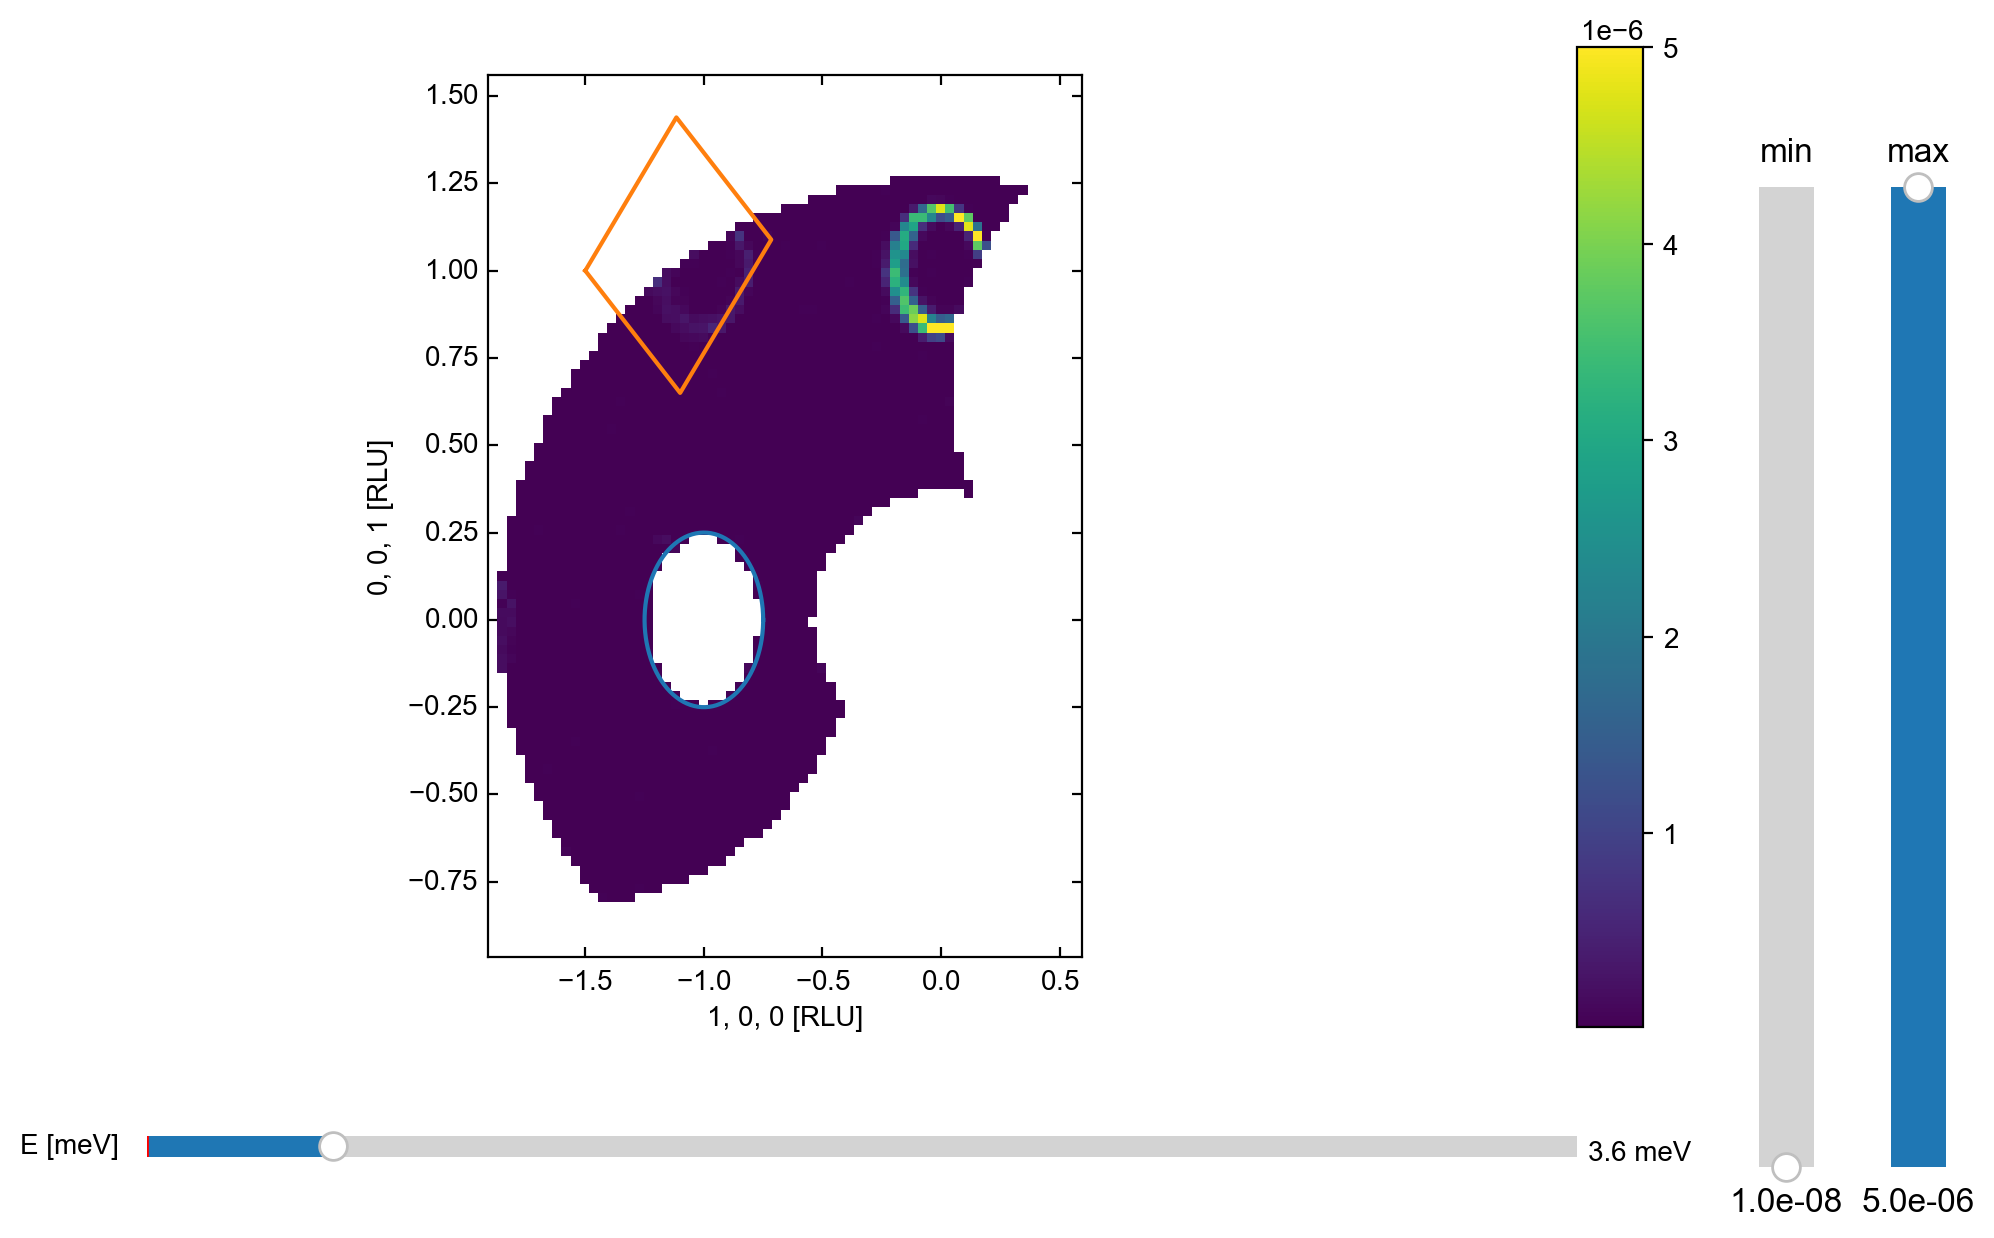

In [6]:
# Generate a 3d viewer
view = ds.View3D(0.05,0.05,0.05)
# it is started in the hkl plane, where we can also plot our masks.
# However, the transformation used by view3D is from qx,qy to hkl, so the inverse
# is to be provided. This is stored in
trans = view.ax.sample.inv_tr

mask.plot(view.ax,transformation=trans,zorder=20)

# tune the colorbar
view.caxis=(1e-8,5e-6)

view.Energy_slider.set_val(10)
view.ax.get_figure()


As seen above, the data within the blue mask are masked out. This is because the energy transfer is within the <code>lowEnergy</code> mask but data within the orange rectangle are present. Changing the energy to be outside the <code>lowEnergy</code> mask enables the orange mask:

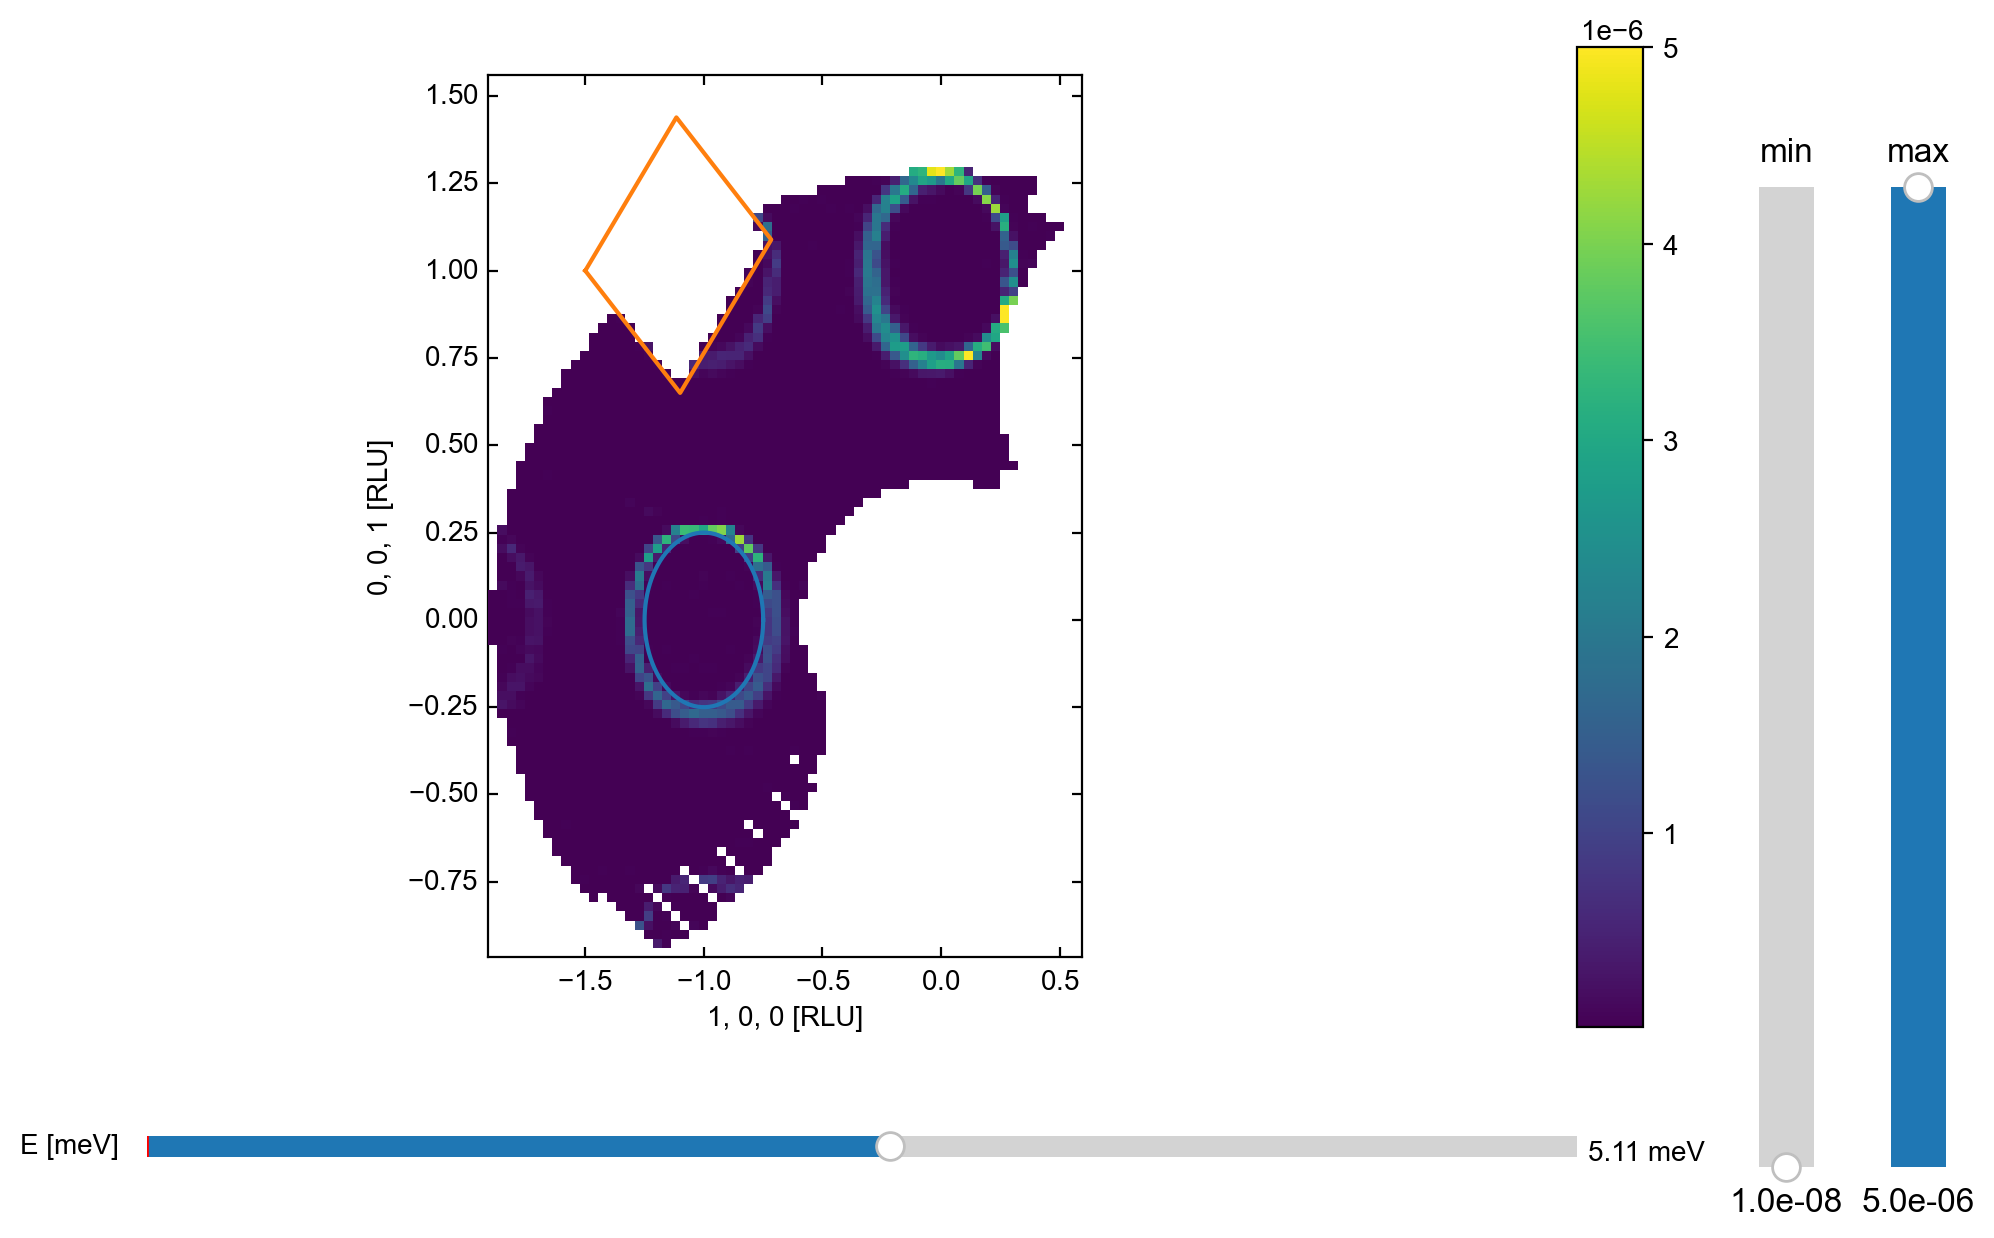

In [7]:
view.Energy_slider.set_val(40)
view.ax.get_figure()

Lastly, the effect of the masks can also be seen in e.g. a QE cut:

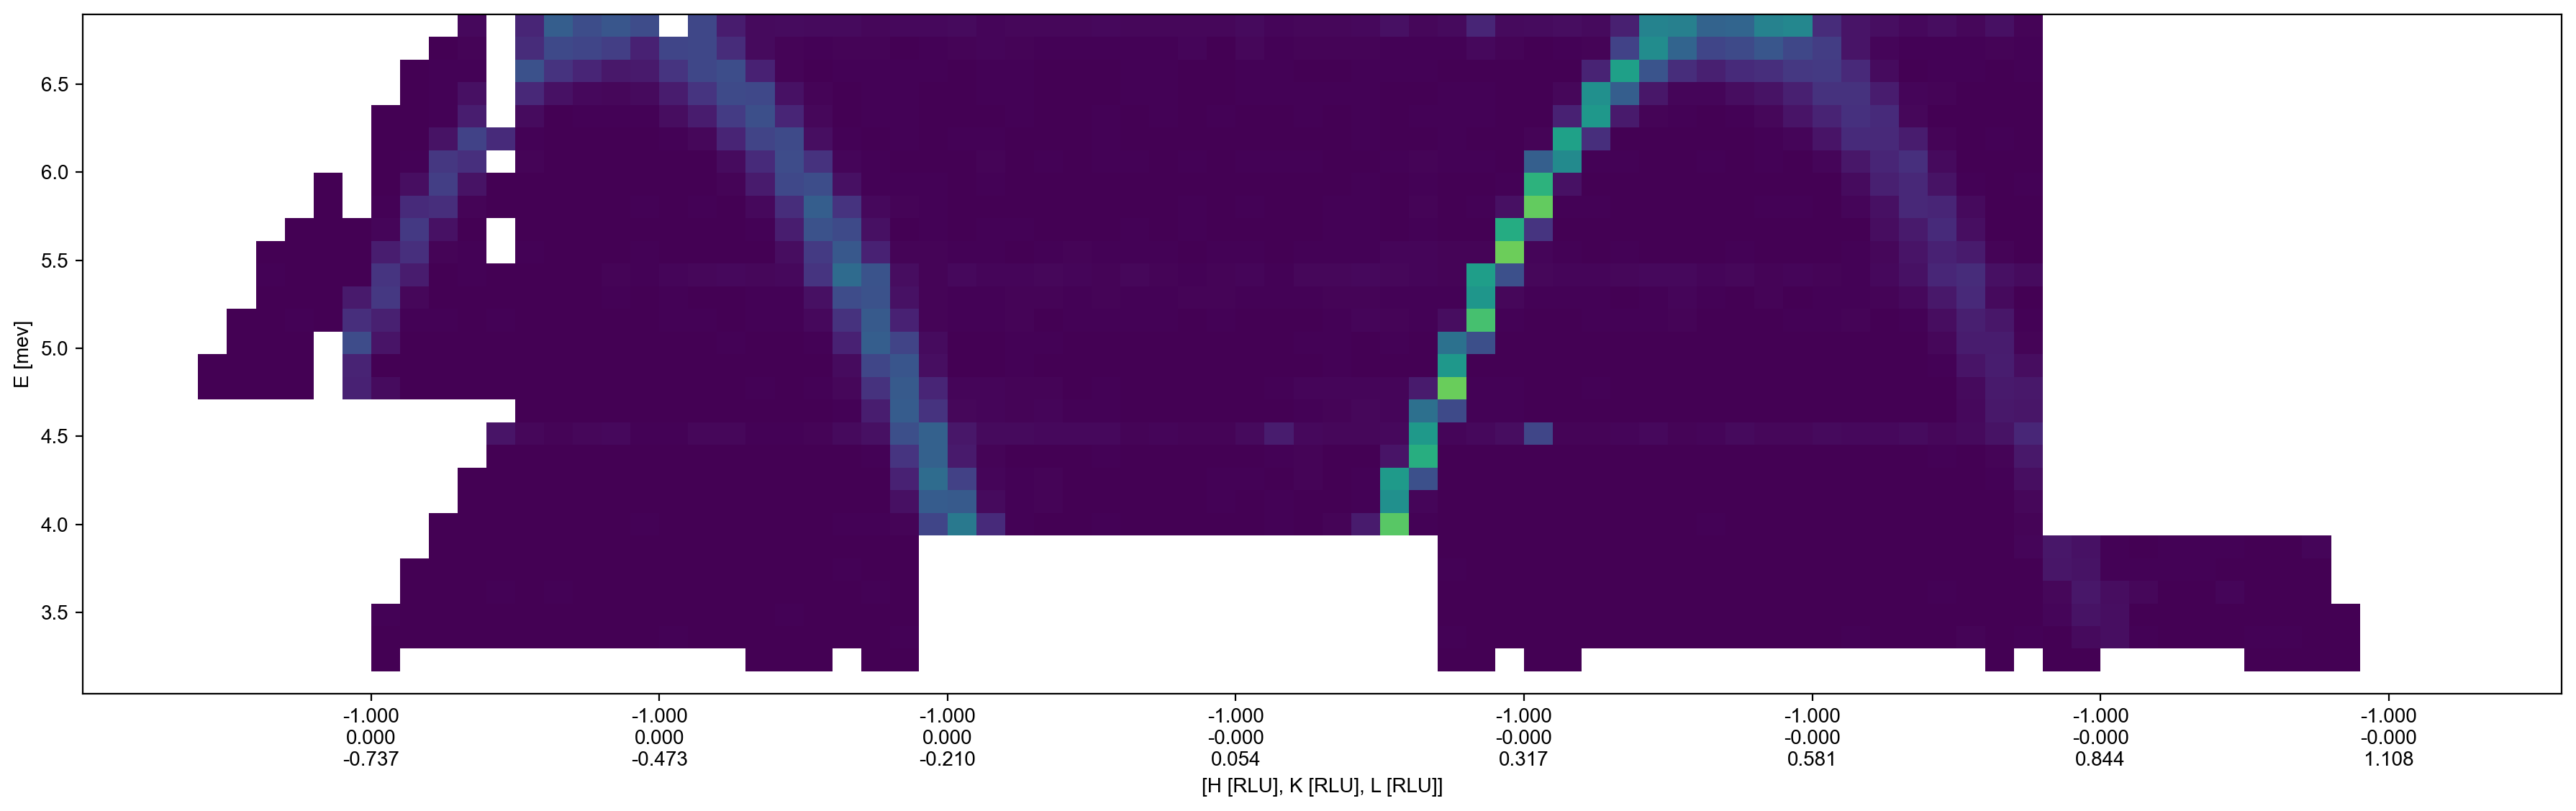

In [8]:
# Along the Q-E direction the masking looks differently
QPoints = np.array([[-1.0,0.0,-1.0],
                [-1.0,0.0,1.25]])
Energies = np.concatenate(ds.energy,axis=0)
EnergyBins = np.linspace(np.min(Energies),np.max(Energies),31)
ax,*_ = ds.plotCutQELine(QPoints=QPoints, width=0.05, minPixel=0.05, \
            EnergyBins=EnergyBins)

# Change the colorbar of the plot
ax.set_clim(0,5e-6)
ax.get_figure()

## Combining Masks

Masking has been implemented into MJOLNIR in such a way, that one can combine masks rather freely. With the above list of possible masks as building blocks, it is believed that almost all masks can be generated by combining the masks with the correct arithmetic operations. Masks are combined using the standard order of operators, meaning that AND (<code>*</code>) operations are performed before OR (<code>+</code>). In additionally, parentheses are allowed making it easier to perform more advanced mask combinations, where multiple masks are to be negated or AND’ed with another masks. This complexity also allows for situations where multiple combinations are equivalent. Using the masks defined in the example, then

$$ (circle*lowEnergy).bar() = circle.bar()*lowEnergy.bar()$$

Behind the scene, a pair-wise tree is created by multiMasks and all operations are propagated through this tree, remembering the mask relations.

## General Features

All of the masks are build on a common base object with a set of methods. In detail, these methods are ensure by the use of a meta class, but the exact implementation is out of scope. What is ensured is that all masks have a <code>__call__</code> and a plot method. The <code>__call__</code> method is used to generate the mask needed in MJOLNIR, and depending on the attributes used to generate a mask it either takes coordinates with the correct dimensionality or an object with attributes matching the coordinates given to the mask. The plot method takes a matplotlib.axes object and, if applicable, a transformation function. This transform is needed when plotting masks on axis having other coordinates than the ones provided to the masks, or if the axis utilizes some sort of transformation under the hood. Unfortunately, this is often the case for MJOLNIR, where RLU, and other axes are used. In the above example, where the masks were to be plotted on an RLU object, the transformation from (h,l) to ($Q_x$,$Q_y$) was to be specified. This is found as an method on the <code>_ax.sample</code> object. Plotting of masks on axes is currently in a non-optimal state. Best way of achieving the goal is to find an example, as above, or simply write the maintainer.

All masks can be combined with each others, independent of their attributes or coordinates as long as the datafile object to be masks has all of these attributes. As explained above, four different arithmetic operations exist, but on top of that, all masks has the bar method. This method simply negates the masks, in effect masking values outside of e.g. the circle, instead of inside.


## Masking Types

Currently, there are 5 different masks, that are supported by MJOLNIR. These covers the main parts, where masks are needed, but might need extension down the line. In ascending order of dimensionality, these are presented below.

### lineMask
The most simple for of masking is in 1D, where values are either inside our outside a given interval. The <code>lineMask</code> requires two attributes (start and end) to generate a mask. It is intended to mask 1D parameters as energy or to be combined with other masks to create more complex maskings. In the above example, the <code>lineMask</code> was used to give an energy dependency on the two masks of $H$ and $L$.

### indexMask
At times it be necessary to perform masking depending on the indices of the points. This could be when a full detector tube is to be masks, but the $A_4$ value is unknown. This can be performed by the indexMask, where a start and end index together with an axis defines the masks.

### circleMask
Increasing in complexity, the next step up is a circular mask where masking of two directions at the same time is possible. One can either proide the center and a point in which the circumference goes through or a center and a radius. If the center is given as a 3D position the masks turns into a spherical masks. Currently, there is no option for elongating the masks in any direction, i.e. to create an ellipse.

### rectangleMask
Instead of only being allowed to mask in circles, one can also mask a rectangle. This can be achieved with the rectangleMask. To create one, a starting corner is to be provided together with a second corner. From these two, the rectangle is created. Alternatively, one can provide 3 points. If this is done, the first two points are used to define an edge, and the last point gives the extend of the rectangle orthogonal to this edge. That is, the third point might not be located on the edge of the rectangle. This three-input option allows the creation of rotated rectangles. Points are then masked by rotating then such that the rectangle lines up with the coordinate axes and center at (0,0). This allows for two simple 1D checks.

### boxMask
Extending the rectangle into 3D creates the boxMask. This mask also supports two different inputs; either three corner points making the edges of the box parallel to the coordinate axes, or 4 point input. In this latter case, the two first points creates on edge, which is extended to form a rectangular base with width corresponding to the orthogonal distance to the third point. Lastly, this rectangle is extended by the orthogonal distance to the last point. Like the <code>rectangleMask</code>, points are masked by rotating the box such that it center is in (0,0,0) and edges are along the coordinate axes. Due to the complexity of 3D rotations, three rotations matrices are involved.

### CurratAxeMask
In all experiments having a strong Bragg peak, be it either magnetic or structural, there is a high chance that the accidental scattering of it polutes the inelastic signals. This mask traces out the paths of the spurions originating from the provided Bragg peaks across all scans.